In [ ]:
import os
import numpy as np
import pandas as pd
import joblib
import pickle

# ML & preprocessing
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
TRAIN_CSV = "train.csv"
assert os.path.exists(TRAIN_CSV), f"{TRAIN_CSV} not found. Upload it to Colab."

df_train = pd.read_csv(TRAIN_CSV)
TARGET = "price_range"

print("Train shape:", df_train.shape)
print(df_train[TARGET].value_counts())


Train shape: (2000, 21)
price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


In [ ]:
def create_features(df):
    df = df.copy()
    df["px_area"] = df["px_height"] * df["px_width"]
    df["ppi_proxy"] = (df["px_height"] + df["px_width"]) / (df["sc_h"] * df["sc_w"] + 1e-6)
    df["mem_ratio"] = df["int_memory"] / (df["ram"] + 1e-6)
    df["battery_per_wt"] = df["battery_power"] / (df["mobile_wt"] + 1e-6)
    df["camera_total"] = df["fc"] + df["pc"]
    for c in ["ram", "px_area", "px_width", "px_height", "battery_power", "int_memory"]:
        df[f"log_{c}"] = np.log1p(df[c].clip(lower=0))
    df["connectivity_score"] = df[["blue","four_g","three_g","wifi","touch_screen","dual_sim"]].sum(axis=1)
    df.fillna(0, inplace=True)
    return df

df_train = create_features(df_train)


In [ ]:
feature_cols = [c for c in df_train.columns if c not in [TARGET, "id"]]
X = df_train[feature_cols]
y = df_train[TARGET].values


In [ ]:
# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("pt", PowerTransformer(method="yeo-johnson")),
        ("scaler", StandardScaler())
    ]), feature_cols)
], remainder="drop")

# Feature selector using LightGBM importance
feature_selector = SelectFromModel(
    lgb.LGBMClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    threshold="median"  # keep only top 50% important features
)


In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(y)),
    n_estimators=2000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('model', lgb_model)
])

full_pipeline.fit(X, y)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3778
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('pt',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['battery_power', 'blue',
                                                   'clock_speed', 'dual_sim',
                                                   'fc', 'four_g', 'int_memory',
                                                   'm_dep', 'mobile_wt',
                                                   'n_cores', 'pc', 'px_height',
                                                   'px_width', 'ram', 'sc_h',
                                                   'sc_w', 'talk_time',
                                                   'three_g', 'touch_screen',
                                                   'wifi', 'px_area',
                                                   'ppi_proxy', 'mem_ratio',
                                                   'battery_per_wt',
                                                   'camera_total', 'log_ram',
                                                   'log_px_area',
                                                   'log_px_width',
                                                   'log_px_height',
                                                   'log_battery_power', ...])])),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(n_estimators=500,
                                                          n_jobs=-1,
                                                          random_state=42),
                                 threshold='median')),
                ('model',
                 LGBMClassifier(n_estimators=2000, n_jobs=-1, num_class=4,
                                objective='multiclass', random_state=42))])

In [ ]:
def oof_score(pipeline, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros(len(y), dtype=int)

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        pipeline.fit(X_tr, y_tr)
        oof_preds[val_idx] = pipeline.predict(X_val)

    acc = accuracy_score(y, oof_preds)
    f1 = f1_score(y, oof_preds, average="macro")
    print(f"OOF Accuracy: {acc:.4f}")
    print(f"OOF F1 (macro): {f1:.4f}")

oof_score(full_pipeline, X, y)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3776
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3778
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3778
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3778
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3778
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 32
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


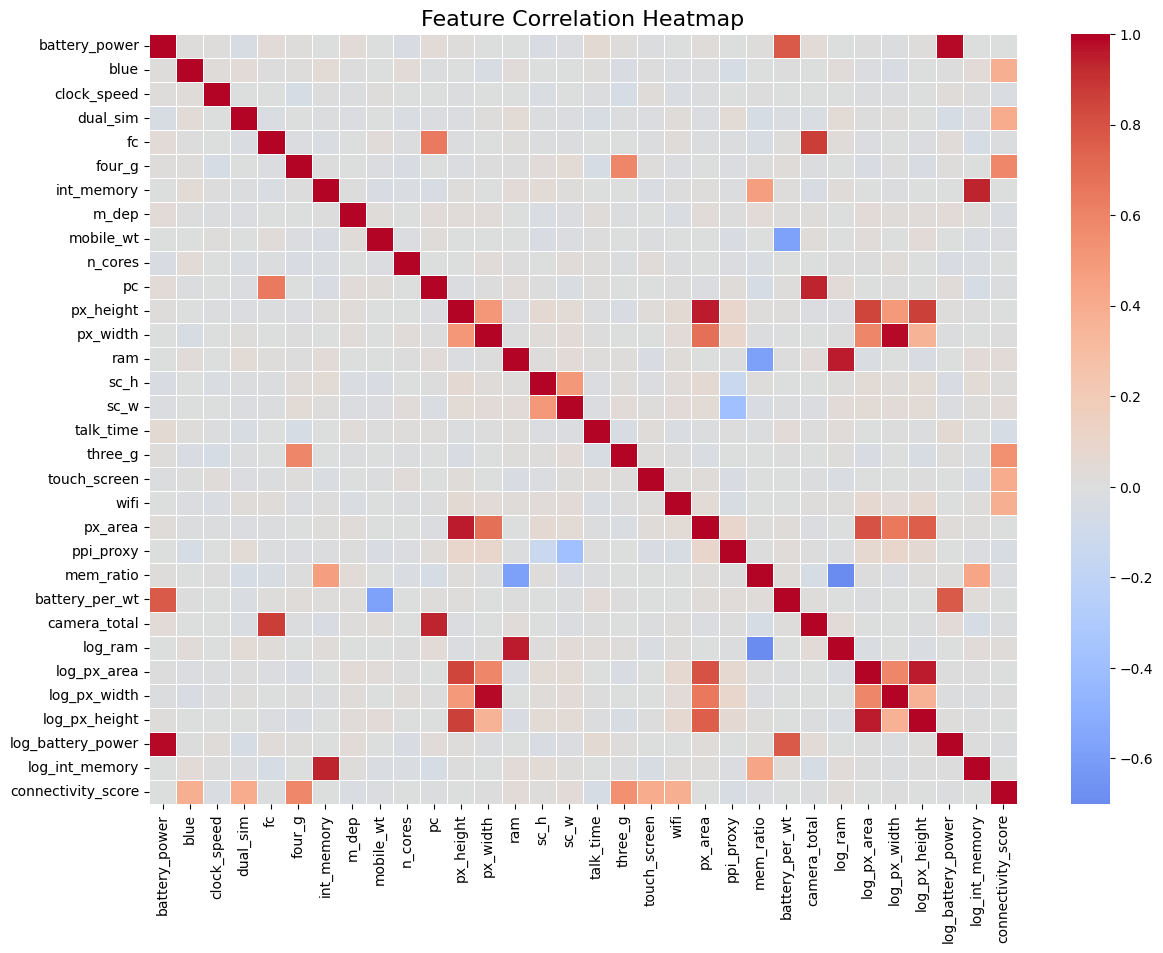

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (exclude target for clarity, or include if you want)
corr = df_train.drop(columns=[TARGET]).corr()

# Set up plot
plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,     # change to True if you want numbers inside
    fmt=".2f",
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


In [ ]:
with open("lgb_pipeline.pkl", "wb") as f:
    pickle.dump(full_pipeline, f)

print("Pipeline with preprocessing, feature selection, and model saved as lgb_pipeline.pkl")


Pipeline with preprocessing, feature selection, and model saved as lgb_pipeline.pkl


In [ ]:

# Sample input with raw features only
sample = {
    "battery_power": 1500,
    "blue": 1,
    "clock_speed": 2.5,
    "dual_sim": 1,
    "fc": 5,
    "four_g": 1,
    "int_memory": 32,
    "m_dep": 0.6,
    "mobile_wt": 150,
    "n_cores": 4,
    "pc": 13,
    "px_height": 800,
    "px_width": 1200,
    "ram": 3000,
    "sc_h": 12,
    "sc_w": 6,
    "talk_time": 15,
    "three_g": 1,
    "touch_screen": 1,
    "wifi": 1
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample])

# Apply the same feature engineering as training
sample_df = create_features(sample_df)

# Predict
pred = full_pipeline.predict(sample_df)
print("Predicted price_range:", pred[0])


Predicted price_range: 3


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
